In [2]:
import torch
import matplotlib.pyplot as plt
from accelerate import Accelerator
from tqdm import tqdm

from m2_utilities.load_data import load_trajectories
from m2_utilities.qwen import load_qwen
from m2_utilities.metrics import gen_points, predict_next_points, compute_mae, compute_mrae
from m2_utilities.preprocessor import scale
from m2_utilities.flops import compute_flops_gen


%load_ext autoreload
%autoreload 2

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


### Loading the Model and Data

In [3]:
# Model
model, tokenizer = load_qwen()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [4]:
# Loading trajectories
trajectories = load_trajectories("data/lotka_volterra_data.h5")

test_trajectories = scale(trajectories[850:])

### Forecasting and Computing Metrics

In [18]:
forecasts = predict_next_points(model, test_trajectories, n_predictions=20, decimals=3)

100%|██████████| 20/20 [03:21<00:00, 10.05s/it]


In [21]:
forecasts_tensor = torch.tensor(forecasts)
test_trajectories = test_trajectories.to(device="cpu")


pred_mae = compute_mae(test_trajectories[:, 80:, 0], forecasts_tensor[:, :, 0])
prey_mae = compute_mae(test_trajectories[:, 80:, 1], forecasts_tensor[:, :, 1])

pred_mrae = compute_mrae(test_trajectories[:, 80:, 0], forecasts_tensor[:, :, 0])
prey_mrae = compute_mrae(test_trajectories[:, 80:, 1], forecasts_tensor[:, :, 1])

print(f"Predator MAE: {pred_mae:.4f}")
print(f"Prey MAE: {prey_mae:.4f}")
print(f"Predator MRAE: {pred_mrae:.4f}")
print(f"Prey MRAE: {prey_mrae:.4f}")

Predator MAE: 0.0350
Prey MAE: 0.0140
Predator MRAE: 0.0314
Prey MRAE: 0.0264


/tmp/ipykernel_4109528/1595498869.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forecasts_tensor = torch.tensor(forecasts)


In [22]:
flops = 20 * compute_flops_gen(100, 1, batch_size=150)
print((flops/1e17)*100)

0.23861962668300002


### Visualising Autoregressive Inference of Time Points

In [23]:
future_points = gen_points(model, test_trajectories[:1, :55], n_points=25, decimals=3)

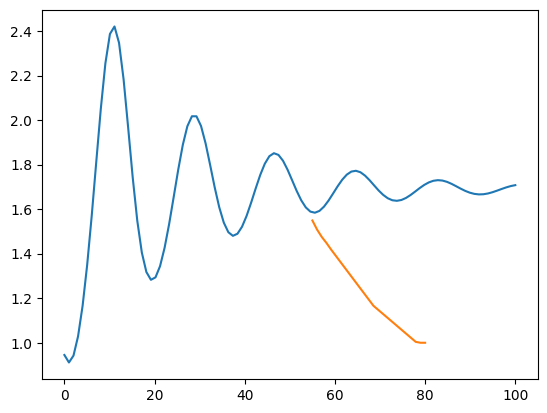

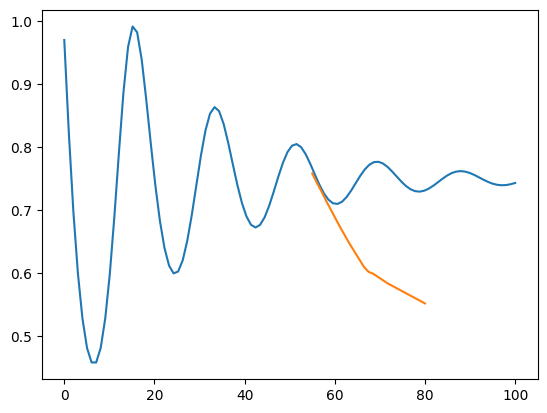

In [24]:
N_FORECAST = 25
plt.plot(torch.linspace(0, 100, 100), test_trajectories[5, :, 0])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), future_points[0, :, 0])
plt.show()

plt.plot(torch.linspace(0, 100, 100), test_trajectories[5, :, 1])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), future_points[0, :, 1])
plt.show()